# Imports Data, Package

In [1]:
import os, gdown

# if not os.path.exists('./old_data'):
#   url = "https://drive.google.com/uc?id=1-1zSgxLw1uTUmSg38ZPUMHAYZIdC0dS-"
#   output = "./old_column_data.zip"
#   gdown.download(url, output, quiet=True)
  
#   !unzip -qq "./old_column_data.zip"
#   !rm ./old_column_data.zip

#   url = "https://drive.google.com/uc?id=1nloaUYMPXNZAA_LYhpjza0RVt7IyGqmI"
#   output = "./column_data.zip"
#   gdown.download(url, output, quiet=True)
#   !unzip -qq "./column_data.zip"
#   !rm ./column_data.zip

#   url = "https://drive.google.com/uc?id=1--DWL6wB3RC1RpMbUPJ4zsZ6ylPKKkUg"
#   output = "./row_data.zip"
#   gdown.download(url, output, quiet=True)
#   !unzip -qq "./row_data.zip"
#   !rm ./row_data.zip
  

# All of these are Faster RCNN models with ResNet-50 backbone
MODEL_CONFIGS_LINKS = {'HJDataset': 'https://www.dropbox.com/s/j4yseny2u0hn22r/config.yml?dl=1', 
                'MFD': 'https://www.dropbox.com/s/ld9izb95f19369w/config.yaml?dl=1',
                'NewspaperNavigator': 'https://www.dropbox.com/s/wnido8pk4oubyzr/config.yml?dl=1', 
                'PubLayNet': 'https://www.dropbox.com/s/f3b12qc4hc0yh4m/config.yml?dl=1', 
                 'TableBank': 'https://www.dropbox.com/s/7cqle02do7ah7k4/config.yaml?dl=1'}

# -------------------------------------------------------------------------------------------------------------------

# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' --quiet

import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import time
#from pycocotools.coco import COCO
import os, json, cv2, random
import copy
from typing import Optional
import random
from PIL import Image

import torch


import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.engine.hooks import HookBase
import detectron2.utils.comm as comm
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator

import imagesize, pickle
from sklearn.preprocessing import LabelEncoder


setup_logger()

# --------------------------

seed = 42
os.environ["PL_GLOBAL_SEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


2022-10-16 17:18:34.731249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shady/anaconda3/envs/py37/lib/python3.7/site-packages/cv2/../../lib64:
2022-10-16 17:18:34.731277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load and create Data

In [ ]:
def process_old_data(main_dir_path = "./old_data"):

  file_dirs = os.listdir(main_dir_path)
  all_csv_files = []
  all_csv_file_paths = []

  for fdir in file_dirs:
      
      temp_dir = main_dir_path + "/" + fdir
      temp_all_files = os.listdir(temp_dir)
      for file in temp_all_files:
          if file.endswith('.csv'):
              all_csv_file_paths.append(main_dir_path+"/"+fdir+"/"+file)   

  df = pd.read_csv(all_csv_file_paths[0])
  df['file_path'] = df['file_name'].apply(lambda x: '/'.join(all_csv_file_paths[0].split('/')[:-1])+'/'+x)

  for i in all_csv_file_paths[1:]: # because first file is the BASE df 
    temp = pd.read_csv(i)
    temp['file_path'] = temp['file_name'].apply(lambda x: '/'.join(i.split('/')[:-1])+'/'+x)

    df = pd.concat([df,temp], ignore_index = True)

  df = df[df['classes'] == 'Question_option_answer']

  res = []
  for i in df['file_path'].values:
    try:
      p = imagesize.get(i)
      res.append(p)
    except:
      res.append(np.nan)

  df['wh'] = res

  df['width'] = df['wh'].apply(lambda x: x[0] if isinstance(x,tuple) else 0)
  df['height'] = df['wh'].apply(lambda x: x[1] if isinstance(x,tuple) else 0)

  df  = df[df['width'] > 0]

  df.replace({'Question_option_answer':0},inplace = True)

  df.rename(columns = {'classes':'category_id'}, inplace = True)

  df['category_id'] = 0 # depends on thing_classes

  return df.reset_index(drop = True)


def process_new_data(PATH = './annotationData/'):
  files = [PATH+i for i in os.listdir(PATH) if not i.endswith('.csv')]

  df = pd.read_csv(files[0].replace('png','csv'))
  df['file_path'] = files[0]

  for im_path in files[1:]: # because first file is the BASE df 
    temp = pd.read_csv(im_path.replace('png','csv'))
    temp['file_path'] = im_path

    df = pd.concat([df,temp], ignore_index = True)


  df['file_name'] = df['file_path'].apply(lambda x: x.split('/')[-1])
  
  df['wh'] = df['file_path'].apply(lambda x: imagesize.get(x))
  df['width'] = df['wh'].apply(lambda x: x[0] if isinstance(x,tuple) else 0)
  df['height'] = df['wh'].apply(lambda x: x[1] if isinstance(x,tuple) else 0)
  df['category_id'] = 0

  df = df.drop(["Unnamed: 0","boundingBoxId","label","status"],axis = 1)
  return df.reset_index(drop = True)


# -------------------------------------------------------------------------------------------------------

old = process_old_data()
column_data = process_new_data("./column_data/")
row_data = process_new_data("./row_data/")

# df = pd.concat([old,column_data], ignore_index = True)
df = pd.concat([old,column_data,row_data], ignore_index = True)
df.rename(columns = {'xmin':'x_min','ymin':'y_min','xmax':'x_max','ymax':'y_max'}, inplace = True)

df = df.applymap(lambda x: round(x,2) if isinstance(x,float) else x) # Rounding off the values
df = df.drop_duplicates(subset = ['x_min','y_min','x_max','y_max'])

le = LabelEncoder()
df['image_id'] = le.fit_transform(df['file_path'])


train_df = df.loc[:,["image_id", "category_id",	"x_min", "y_min", "x_max", "y_max"]]
train_meta = df.loc[:,["image_id", "file_path", "width",	"height"]]
debug=False
split_mode="valid20" # all_train Or  valid20 
thing_classes = ['text']

Data_Resister_training="PL_data_train"
Data_Resister_valid="PL_data_valid"


# --------------------------------------------------------------------------------------------------

def get_PL_data_dicts(
    _train_df: pd.DataFrame,
    _train_meta: pd.DataFrame,
    use_cache: bool = True,
    target_indices: Optional[np.ndarray] = None,
    debug: bool = False,
    data_type:str="train"
   
):
    if debug:
            train_meta = train_meta.iloc[:100]  # For debug...
    dataset_dicts = []
    for index, train_meta_row in tqdm(_train_meta.iterrows(), total=len(_train_meta)):
                    record = {}
                    image_id,file_name, width,height = train_meta_row.values
                    record["file_name"] = file_name
                    record["image_id"] = image_id
                    record["width"] = width
                    record["height"] = height
                    objs = []
                    for index2, row in _train_df.query("image_id == @image_id").iterrows():
                        class_id = row["category_id"]
                        bbox_resized = [
                            float(row["x_min"]),
                            float(row["y_min"]),
                            float(row["x_max"]),
                            float(row["y_max"]),
                        ]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    record["annotations"] = objs
                    dataset_dicts.append(record)
                    
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts


n_dataset = len(train_meta)


n_train = int(n_dataset * 0.95)
print("n_dataset", n_dataset, "n_train", n_train)

rs = np.random.RandomState(12)
inds = rs.permutation(n_dataset)
train_inds, valid_inds = inds[:n_train], inds[n_train:]
DatasetCatalog.register(
    Data_Resister_training,
    lambda: get_PL_data_dicts(
        train_df,
        train_meta,
        target_indices=train_inds,
        debug=debug,
        data_type="train"
    ),
)
MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)


DatasetCatalog.register(
    Data_Resister_valid,
    lambda: get_PL_data_dicts(
        train_df,
        train_meta,
        target_indices=valid_inds,
        debug=debug,
        data_type="val"
        ),
    )
MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)

dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)


print("Training size: ",len(dataset_dicts_train),"|| Validation size: ",len(dataset_dicts_valid))

dataset_dicts_train[20]
                                  

n_dataset 8805 n_train 8364


  0%|          | 0/8805 [00:00<?, ?it/s]

  0%|          | 0/8805 [00:00<?, ?it/s]

Training size:  8364 || Validation size:  441


{'file_name': './column_data/947e52fb-715b-4c06-8cfb-afffe0614e60.png',
 'image_id': 586,
 'width': 1100,
 'height': 519,
 'annotations': [{'bbox': [48.65, 25.3, 541.06, 177.11],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0},
  {'bbox': [46.7, 182.95, 539.11, 428.18],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0},
  {'bbox': [603.34, 23.36, 1076.29, 206.31],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0},
  {'bbox': [601.39, 212.14, 1080.18, 451.54],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0}]}

# Custom Training / Val loop

In [ ]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                # log_every_n_seconds(
                #     logging.INFO,
                #     "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                #         idx + 1, total, seconds_per_img, str(eta)
                #     ),
                #     n=5,
                # )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)

        mean_loss = np.mean(losses)
        print(f"Mean Val Loss: {mean_loss}")
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
        
        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)



# -------------------------------------------

def custom_mapper(dataset_dict, transform_list = None):
    
    if transform_list is None:
      transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomContrast(0.8, 1.2),
                      T.RandomSaturation(0.8, 1.2),
                      ]
                      
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
                      
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class AugTrainer(DefaultTrainer): # Trainer with augmentations
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

# Model Building and Training

In [5]:
if not os.path.exists("./config.yml"): # 
  # get the link  detail from MODEL_CONFIGS_LINKS
  !wget -qq -O ./config.yml "https://www.dropbox.com/s/f3b12qc4hc0yh4m/config.yml?dl=1"

In [ ]:
def modify_config(config_path):
    
    cfg = get_cfg()
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


    cfg.merge_from_file(config_path)

    # cfg.CUDNN_BENCHMARK = True #  Default False
    cfg.DATALOADER.NUM_WORKERS: 2

    cfg.DATASETS.TRAIN = (Data_Resister_training,)
    cfg.DATASETS.TEST = (Data_Resister_valid,)

    cfg.TEST.EVAL_PERIOD = 20 # Evaluate after N epochs

    # cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # Default 256 . More the number, more the memory consumption
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # in config file, it is written before weights

    # If using config.ym file for any pre trained model, weights path is already there so no need to download weights
    # cfg.MODEL.WEIGHTS= './faster_rcnn_R_50_FPN_3x.pth' # layout parser Pre trained weights 

    cfg.MODEL.MASK_ON = False # In case we have used Mask RCNN model


    cfg.SOLVER.IMS_PER_BATCH = 4 # Batch size
    cfg.SOLVER.BASE_LR = 0.0025
    cfg.SOLVER.WARMUP_ITERS = 50
    cfg.SOLVER.MAX_ITER = 1000 # adjust up if val mAP is still rising, adjust down if overfit
    cfg.SOLVER.STEPS = (300, 800) # must be less than  MAX_ITER 
    cfg.SOLVER.GAMMA = 0.05
    cfg.SOLVER.CHECKPOINT_PERIOD = 20  # Save weights after these many steps

    return cfg


# Training using custom trainer defined aboves
trainer = AugTrainer(cfg) # DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

trainer.train()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp  /content/drive/MyDrive/model_219.pth ./model_weights.pth
# !cp /content/output/publaynet/faster_rcnn_R_50_FPN_3x/model_0000139.pth /content/drive/MyDrive/model_139.pth
# !cp /content/output/publaynet/faster_rcnn_R_50_FPN_3x/model_0000159.pth /content/drive/MyDrive/model_159.pth
# !cp /content/output/publaynet/faster_rcnn_R_50_FPN_3x/model_0000179.pth /content/drive/MyDrive/model_179.pth
# !cp /content/output/publaynet/faster_rcnn_R_50_FPN_3x/model_0000199.pth /content/drive/MyDrive/model_199.pth

In [ ]:
def build_test(cfg_path, model_weights_path):
  if isinstance(cfg_path, str): 
    with open(cfg_path, "rb") as f: cfg_ = pickle.load(f)
  else: cfg_ = cfg

  if not torch.cuda.is_available(): cfg.MODEL.DEVICE = "cpu" 

  cfg_.MODEL.WEIGHTS = model_weights_path
  cfg_.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
  predictor = DefaultPredictor(cfg_)
  return predictor


# predictor = build_test('/content/drive/MyDrive/publay_config_1.pkl',"/content/output/publaynet/faster_rcnn_R_50_FPN_3x/model_0000219.pth")
# predictor = build_test(cfg,"./model_weights.pth")



# image_name = random.choice(dataset_dicts_valid)['file_name']
image_name = "/content/76e3d311-6cfb-445b-b13f-2f321cd27f7b.png"


image = cv2.imread(image_name)
output = predictor(image)

v = Visualizer(image[:,:,::-1])
v = v.draw_instance_predictions(output['instances'].to('cpu'))


Image.fromarray(v.get_image())

# Connect DB

In [ ]:
!rm -rf ./annotationData/

# DELETE EXTRA

In [1]:
import json
from utils.data_utils import *
from utils.train_test_utils import *

Data_Resister_training = "my_train_data"
Data_Resister_valid = "my_val_data"
thing_classes = ["Questions_Options"]
json_file_or_path = "./layout_3/annot.json"

_ = build_register_detectron_data(json_file_or_path, Data_Resister_training, Data_Resister_valid, thing_classes)

2022-10-16 17:56:46.050918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shady/anaconda3/envs/py37/lib/python3.7/site-packages/cv2/../../lib64:
2022-10-16 17:56:46.050942: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)


dataset_dicts_valid[1]

{'file_name': './layout_3/0133e4bd-d05e-4782-b52f-e1e5f8f589ac.png',
 'image_id': 576,
 'width': 1100,
 'height': 1478,
 'annotations': [{'bbox': [92.0, 431.0, 1016.0, 662.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0},
  {'bbox': [102.0, 688.0, 996.0, 1364.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0}]}

In [3]:
cfg = build_layoutParser_faster_rcnnn_config('PubLayNet', Data_Resister_training, Data_Resister_valid)
trainer = AugTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

[10/16 17:56:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# ----------------------------

In [1]:
from utils import *

2022-10-18 18:26:47.124547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shady/anaconda3/envs/py37/lib/python3.7/site-packages/cv2/../../lib64:
2022-10-18 18:26:47.124576: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
blur = BLUR(5)
fog = RandomFog(p = 1)
equalize_image = Equalize(p = 1)
to_sepia = ToSepia(p = 1)
invert = InvertImg(p = 1)

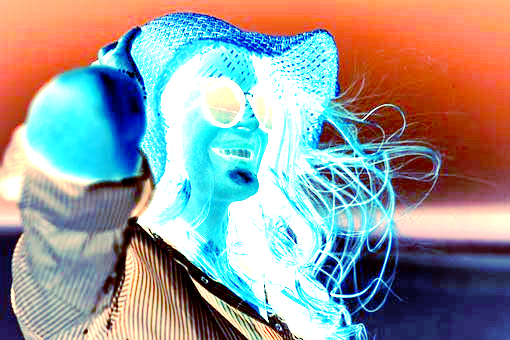

In [14]:

import numpy as np
from PIL import Image
import cv2

augs = KRandomAugmentationList(
        [
        CustomAug(random_shadow, prob = 0.33),
        KRandomAugmentationList([CustomAug(channel_shuffle, prob = 0.9),CustomAug(rgb_shift, prob = 0.9), CustomAug(invert.apply, prob = 0.3)], k = 1),

        KRandomAugmentationList([CustomAug(random_gamma, prob = 0.5), T.RandomBrightness(0.4,1.4),T.RandomSaturation(0.4,1.4), T.RandomContrast(0.4,1.4)],k = -1),
        
        KRandomAugmentationList([CustomAug(random_noise, prob=0.75), CustomAug(blur.add_blur, prob=0.75), CustomAug(fog.apply, prob=0.75)], k = 1),

        KRandomAugmentationList([CustomAug(F_.to_gray, prob = 0.75), CustomAug(to_sepia.apply, prob = 0.7), CustomAug(fancy_pca, prob=0.7), CustomAug(equalize_image.apply, prob = 0.4)], k = 1),
        ],
        
        k = -1)


image = np.array(Image.open("/home/shady/Downloads/image.jpeg")) # RGB image array
# image = cv2.imread("/home/shady/Downloads/download4.jpeg")
input_ = T.AugInput(image, boxes=None, sem_seg = None) #1 boxes and segments are optional
transform = augs(input_)  # Apply the augmentation
image_transformed = input_.image  # augmented image

Image.fromarray(image_transformed) # show RGB image
